# Dynamic Position Sizing & Stop-Loss Implementation

**Jonathan Gil**

**Last Updated: November 3, 2025**


Goal: Implement portfolio adjustments based on risk score and stop-loss rules.

Task:
- Create PositionSizing_And_StopLoss.ipynb.
- Given signals + risk scores → allocate capital (less for risky assets).
  - CSV:
    - ticker,score,risk_score,price
    - AAPL,0.80,0.074,185.3
    - MSFT,0.60,0.056,317.5
- Add a stop-loss rule (e.g., sell if price drops > 5 % from entry).
- Research stop-loss rules to determine optimal stopping points
- Output positions.csv with Ticker, Weight, StopLoss.
  - ticker,weight,capital,stop_loss
  - AAPL,0.55,55000,176.0
  - MSFT,0.45,45000,301.6
- Outcome: Realistic capital allocation + risk protection mechanism

### Methodology

Position sizing should allocate **more capital to higher-scoring, lower-risk assets**.

### Formulas:
```
Combined Score = Signal Score / (1 + Risk Score)
Raw Weight = Combined Score / Sum(All Combined Scores)
Normalized Weight = Raw Weight × (Capital / Total Capital)
```





## 0) Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



## 1) Load Input Data

We're loading the signals data from ```signals_data.csv```

Signals data contains trading signals and risk assessments for different stocks.


In [2]:
# Load the input data as DataFrame
signals_data_frame = pd.read_csv('signals_data.csv')

print(signals_data_frame)
print(f"\nDataset Shape: {signals_data_frame.shape}")


  ticker  score  risk_score  price
0   AAPL   0.80       0.074  185.3
1   MSFT   0.60       0.056  317.5
2  GOOGL   0.75       0.068  142.8
3   AMZN   0.65       0.082  178.2
4   NVDA   0.85       0.095  875.4
5   TSLA   0.55       0.125  242.6
6   META   0.70       0.078  485.3
7    JPM   0.50       0.045  192.8
8      V   0.68       0.051  278.9
9    WMT   0.45       0.038  168.5

Dataset Shape: (10, 4)


## 2) Position Sizing Algorithm

In [3]:
# This function calculates position sizes given the DataFrame (signal score/risk score/ticker/price)
def calculate_position_sizes(data_frame, total_capital=10000, min_score=0.0):
    
    # Filter DataFrame by minimum score
    data_frame_filtered = data_frame[data_frame['score'] >= min_score].copy()

    # Calculate a risk-adjusted score that deptermines how much capital to allocate for each stock
    # Higher signal score + Lower risk = More allocation
    data_frame_filtered['combined_score'] = data_frame_filtered['score'] / (1 + data_frame_filtered['risk_score'])
    
    # Normalization step:
    # Converts combined scores into weights; they sum to 100% = 1
    total_combined_score = data_frame_filtered['combined_score'].sum()
    data_frame_filtered['weight'] = data_frame_filtered['combined_score'] / total_combined_score
    
    # Calculate capital allocation
    data_frame_filtered['capital_allocated'] = data_frame_filtered['weight'] * total_capital
    
    # Round to 4 or 2 decimal points for simplicity
    data_frame_filtered['weight'] = data_frame_filtered['weight'].round(4)
    data_frame_filtered['capital_allocated'] = data_frame_filtered['capital_allocated'].round(2)
    
    return data_frame_filtered


# Calculate how to allocate capital to each stock using position sizing
total_portfolio_capital = 10000 # Set capital to $10k
positions_data_frame = calculate_position_sizes(signals_data_frame, total_capital=total_portfolio_capital, min_score=0.0)

print("Position Sizing Results:")
print(positions_data_frame[['ticker', 'score', 'risk_score', 'combined_score', 'weight', 'capital_allocated']].to_string(index=False))


Position Sizing Results:
ticker  score  risk_score  combined_score  weight  capital_allocated
  AAPL   0.80       0.074        0.744879  0.1223            1223.21
  MSFT   0.60       0.056        0.568182  0.0933             933.05
 GOOGL   0.75       0.068        0.702247  0.1153            1153.20
  AMZN   0.65       0.082        0.600739  0.0987             986.51
  NVDA   0.85       0.095        0.776256  0.1275            1274.74
  TSLA   0.55       0.125        0.488889  0.0803             802.83
  META   0.70       0.078        0.649351  0.1066            1066.34
   JPM   0.50       0.045        0.478469  0.0786             785.72
     V   0.68       0.051        0.647003  0.1062            1062.48
   WMT   0.45       0.038        0.433526  0.0712             711.92


## 3) Stop Loss

This block calculates the stop-loss prices for each stock in the portfolio.

The stop-loss rule is a safety-mechanism that lets you know when to sell a stock to minimize losses.

In [4]:
def calculate_stop_loss(data_frame, base_stop_pct=0.05, risk_multiplier=50):
    
    data_frame_copy = data_frame.copy()
    
    # Calculate risk-adjusted stop-loss percentage
    # Determines how far a stock price can fall before the stop-loss is triggered
    data_frame_copy['stop_loss_pct'] = base_stop_pct + (data_frame_copy['risk_score'] * risk_multiplier / 100)
    
    # Calculate stop-loss price
    data_frame_copy['stop_loss_price'] = data_frame_copy['price'] * (1 - data_frame_copy['stop_loss_pct'])
    
    # Round to 2 decimal places
    data_frame_copy['stop_loss_pct'] = (data_frame_copy['stop_loss_pct'] * 100).round(2)  # Convert to percentage
    data_frame_copy['stop_loss_price'] = data_frame_copy['stop_loss_price'].round(2)
    
    return data_frame_copy


# Execute the stop-loss calculation function and update DataFrame
positions_data_frame = calculate_stop_loss(positions_data_frame)

print("Stop-Loss Calculation Results:")
print(positions_data_frame[['ticker', 'price', 'risk_score', 'stop_loss_pct', 'stop_loss_price']].to_string(index=False))

print("\nRisk vs Stop-Loss Analysis:")
print(f"{'Ticker':<8} {'Risk Score':<12} {'Stop-Loss %':<12} {'Entry Price':<12} {'Stop Price':<12}")
for _, row in positions_data_frame.iterrows():
    print(f"{row['ticker']:<8} {row['risk_score']:<12.4f} {row['stop_loss_pct']:<12.2f} ${row['price']:<11.2f} ${row['stop_loss_price']:<11.2f}")


Stop-Loss Calculation Results:
ticker  price  risk_score  stop_loss_pct  stop_loss_price
  AAPL  185.3       0.074           8.70           169.18
  MSFT  317.5       0.056           7.80           292.73
 GOOGL  142.8       0.068           8.40           130.80
  AMZN  178.2       0.082           9.10           161.98
  NVDA  875.4       0.095           9.75           790.05
  TSLA  242.6       0.125          11.25           215.31
  META  485.3       0.078           8.90           442.11
   JPM  192.8       0.045           7.25           178.82
     V  278.9       0.051           7.55           257.84
   WMT  168.5       0.038           6.90           156.87

Risk vs Stop-Loss Analysis:
Ticker   Risk Score   Stop-Loss %  Entry Price  Stop Price  
AAPL     0.0740       8.70         $185.30      $169.18     
MSFT     0.0560       7.80         $317.50      $292.73     
GOOGL    0.0680       8.40         $142.80      $130.80     
AMZN     0.0820       9.10         $178.20      $161.98   

## 4) Analysis Charts

Visualizations are saved as ```position_sizing_analysis.png```

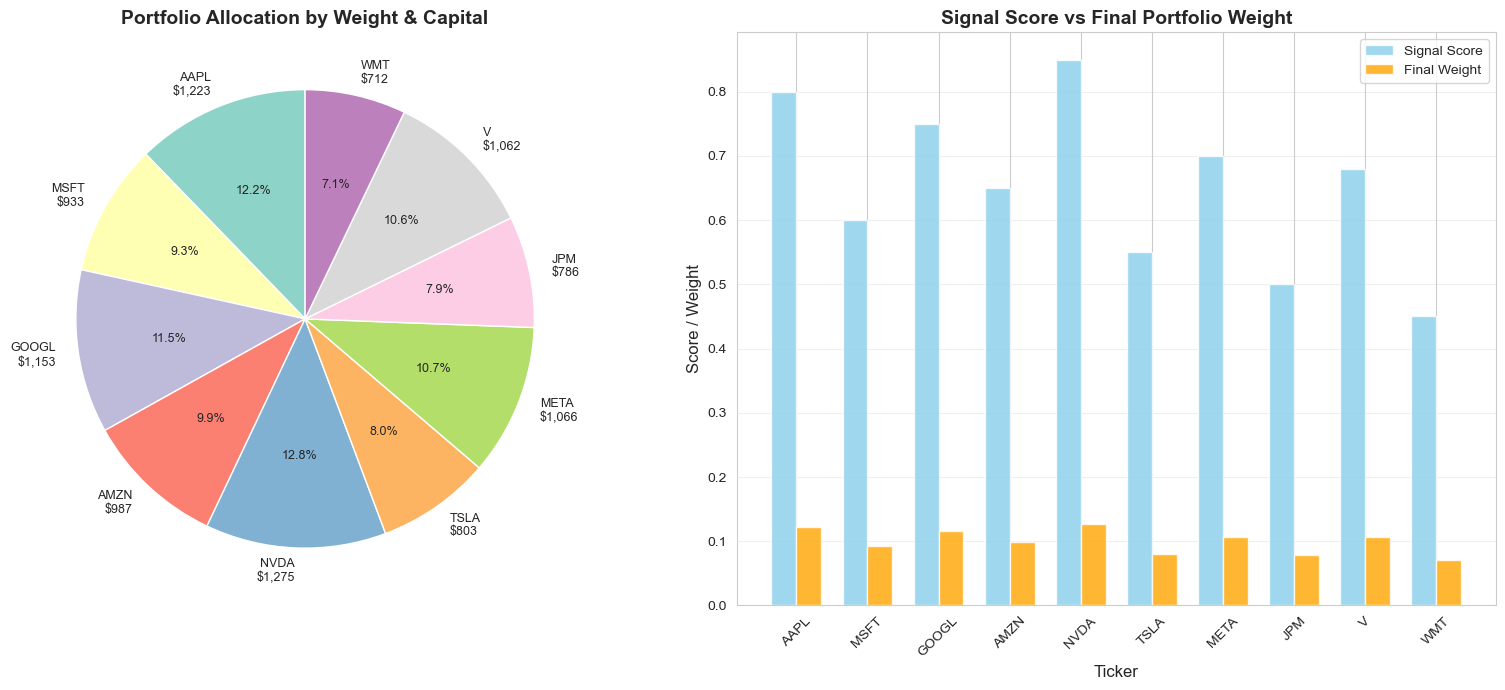

In [5]:
# Create pie chart showing portfolio allocation by weight and capital amount
def plot_portfolio_allocation_pie(ax, data_frame, colors):
    
    # Create custom labels -- ticker and dollar amount
    labels = [f"{ticker}\n${capital:,.0f}" 
              for ticker, capital in zip(data_frame['ticker'], data_frame['capital_allocated'])]
    
    wedges, texts, autotexts = ax.pie(
        data_frame['weight'], 
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9}
    )
    
    ax.set_title('Portfolio Allocation by Weight & Capital', fontsize=14, fontweight='bold')


# Create bar chart -- compares signal scores with final portfolio weights
def plot_score_vs_weight_comparison(ax, data_frame):
    x = np.arange(len(data_frame))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, data_frame['score'], width, 
                   label='Signal Score', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, data_frame['weight'], width, 
                   label='Final Weight', alpha=0.8, color='orange')
    
    ax.set_xlabel('Ticker', fontsize=12)
    ax.set_ylabel('Score / Weight', fontsize=12)
    ax.set_title('Signal Score vs Final Portfolio Weight', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(data_frame['ticker'], rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)


# Create layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

colors = plt.cm.Set3(range(len(positions_data_frame)))

# Call functions to create charts
plot_portfolio_allocation_pie(axes[0], positions_data_frame, colors)
plot_score_vs_weight_comparison(axes[1], positions_data_frame)

# Save charts
plt.tight_layout()
plt.savefig('position_sizing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### 5) Create Final Output CSV

In [6]:
# Create DataFrame with required columns
output_data_frame = positions_data_frame[['ticker', 'weight', 'capital_allocated', 'stop_loss_price']].copy()
output_data_frame.columns = ['ticker', 'weight', 'capital', 'stop_loss']

# Sort by weight (DESCENDING)
output_data_frame = output_data_frame.sort_values('weight', ascending=False).reset_index(drop=True)

# Display output
print("FINAL PORTFOLIO POSITIONS")
print(output_data_frame.to_string(index=False))

print("")

print(f"Total Capital: ${output_data_frame['capital'].sum():,.2f}")

# Save to CSV
output_data_frame.to_csv('positions.csv', index=False)


FINAL PORTFOLIO POSITIONS
ticker  weight  capital  stop_loss
  NVDA  0.1275  1274.74     790.05
  AAPL  0.1223  1223.21     169.18
 GOOGL  0.1153  1153.20     130.80
  META  0.1066  1066.34     442.11
     V  0.1062  1062.48     257.84
  AMZN  0.0987   986.51     161.98
  MSFT  0.0933   933.05     292.73
  TSLA  0.0803   802.83     215.31
   JPM  0.0786   785.72     178.82
   WMT  0.0712   711.92     156.87

Total Capital: $10,000.00


## 4. Risk Metrics


In [7]:
# Calculate portfolio-level risk metrics
portfolio_risk = (positions_data_frame['weight'] * positions_data_frame['risk_score']).sum()
max_loss_at_stops = positions_data_frame.apply(
    lambda row: row['capital_allocated'] * (row['stop_loss_pct'] / 100), 
    axis=1
).sum()

avg_stop_loss_pct = (positions_data_frame['weight'] * positions_data_frame['stop_loss_pct']).sum()

print("="*80)
print("PORTFOLIO RISK METRICS")
print("="*80)
print(f"Total Portfolio Value: ${total_portfolio_capital:,.2f}")
print(f"Weighted Portfolio Risk Score: {portfolio_risk:.4f}")
print(f"Average Stop-Loss %: {avg_stop_loss_pct:.2f}%")
print(f"Maximum Loss if All Stops Hit: ${max_loss_at_stops:,.2f} ({max_loss_at_stops/total_portfolio_capital*100:.2f}%)")
print("="*80)

# Risk concentration
print("\nRisk Concentration by Position:")
positions_data_frame['risk_contribution'] = positions_data_frame['weight'] * positions_data_frame['risk_score']
print(positions_data_frame[['ticker', 'weight', 'risk_score', 'risk_contribution']].sort_values('risk_contribution', ascending=False).to_string(index=False))


PORTFOLIO RISK METRICS
Total Portfolio Value: $10,000.00
Weighted Portfolio Risk Score: 0.0723
Average Stop-Loss %: 8.62%
Maximum Loss if All Stops Hit: $861.65 (8.62%)

Risk Concentration by Position:
ticker  weight  risk_score  risk_contribution
  NVDA  0.1275       0.095           0.012113
  TSLA  0.0803       0.125           0.010037
  AAPL  0.1223       0.074           0.009050
  META  0.1066       0.078           0.008315
  AMZN  0.0987       0.082           0.008093
 GOOGL  0.1153       0.068           0.007840
     V  0.1062       0.051           0.005416
  MSFT  0.0933       0.056           0.005225
   JPM  0.0786       0.045           0.003537
   WMT  0.0712       0.038           0.002706


## 5) Portfolio Summary

In [8]:
print(f"\nPORTFOLIO COMPOSITION")
print(f"   • Number of Positions: {len(positions_data_frame)}")
print(f"   • Total Capital: ${total_portfolio_capital:,.2f}")
print(f"   • Largest Position: {output_data_frame.iloc[0]['ticker']} ({output_data_frame.iloc[0]['weight']:.2%}, ${output_data_frame.iloc[0]['capital']:,.2f})")
print(f"   • Smallest Position: {output_data_frame.iloc[-1]['ticker']} ({output_data_frame.iloc[-1]['weight']:.2%}, ${output_data_frame.iloc[-1]['capital']:,.2f})")

print(f"\nRISK PROFILE")
print(f"   • Portfolio Risk Score: {portfolio_risk:.4f}")
print(f"   • Average Stop-Loss: {avg_stop_loss_pct:.2f}%")
print(f"   • Max Potential Loss: ${max_loss_at_stops:,.2f} ({max_loss_at_stops/total_portfolio_capital*100:.2f}%)")
print(f"   • Highest Risk Asset: {positions_data_frame.nlargest(1, 'risk_score')['ticker'].values[0]} (Risk: {positions_data_frame['risk_score'].max():.3f})")
print(f"   • Lowest Risk Asset: {positions_data_frame.nsmallest(1, 'risk_score')['ticker'].values[0]} (Risk: {positions_data_frame['risk_score'].min():.3f})")

print(f"\nLOGIC")
print(f"   • Allocation Method: Risk-Adjusted Score Weighting")
print(f"   • Stop-LossMethod: Risk-Adjusted Stop-Loss")


PORTFOLIO COMPOSITION
   • Number of Positions: 10
   • Total Capital: $10,000.00
   • Largest Position: NVDA (12.75%, $1,274.74)
   • Smallest Position: WMT (7.12%, $711.92)

RISK PROFILE
   • Portfolio Risk Score: 0.0723
   • Average Stop-Loss: 8.62%
   • Max Potential Loss: $861.65 (8.62%)
   • Highest Risk Asset: TSLA (Risk: 0.125)
   • Lowest Risk Asset: WMT (Risk: 0.038)

LOGIC
   • Allocation Method: Risk-Adjusted Score Weighting
   • Stop-LossMethod: Risk-Adjusted Stop-Loss


## 6) Stop-Loss Signal Generation

This function monitors current market prices and generates stop/loss signals.

**Not currently needed for this task**

In [9]:
# This function monitors current market prices and generates stop/loss signals.
def generate_stop_loss_signals(positions_data_frame, current_prices_data_frame):
  
    signals = []
    
    for idx, position in positions_data_frame.iterrows():
        # Current price for this ticker
        current_price_row = current_prices_data_frame[current_prices_data_frame['ticker'] == position['ticker']]
        
        # If no current price data available, skip this position
        if len(current_price_row) == 0:
            continue
            
        current_price = current_price_row['price'].values[0]
        entry_price = position['price']
        stop_price = position['stop_loss_price']
        
        # Calculate price change percentage
        price_change_percentage = ((current_price - entry_price) / entry_price) * 100
        
        stop_triggered = current_price <= stop_price
        
        signal = {
            'ticker': position['ticker'],
            'signal': 'SELL' if stop_triggered else 'HOLD',
            'entry_price': entry_price,
            'stop_price': stop_price,
            'current_price': current_price,
            'price_change_percentage': round(price_change_percentage, 2),
            'stop_triggered': stop_triggered,
            'risk_score': position['risk_score'],
            'capital_at_risk': position['capital_allocated'] if stop_triggered else 0,
            'estimated_loss': position['capital_allocated'] * (price_change_percentage / 100) if stop_triggered else 0
        }
        
        signals.append(signal)
    
    return pd.DataFrame(signals)

